In [157]:
import yfinance as yf
import numpy as np
import pandas as pd

# Define the ticker symbol
ticker = "AAPL"

In [158]:
data = yf.download(ticker)

[*********************100%***********************]  1 of 1 completed


In [159]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
1980-12-12,0.098834,0.099264,0.098834,0.098834,469033600
1980-12-15,0.093678,0.094108,0.093678,0.094108,175884800
1980-12-16,0.086802,0.087232,0.086802,0.087232,105728000
1980-12-17,0.088951,0.089381,0.088951,0.088951,86441600
1980-12-18,0.091530,0.091960,0.091530,0.091530,73449600


In [160]:
data.to_csv('data.csv', index=False)

In [161]:
data = data.dropna()

In [162]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [163]:
data = pd.DataFrame(data_normalized, columns=data.columns)
train_size = int(len(data) * 0.75)
train_data = data[:train_size]
test_data = data[train_size:]

In [164]:
test_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
8330,0.065906,0.065941,0.065753,0.065683,0.058803
8331,0.068441,0.068230,0.067923,0.068407,0.067547
8332,0.068150,0.068369,0.068319,0.068635,0.022577
8333,0.067696,0.068084,0.067998,0.068419,0.027488
8334,0.067238,0.067474,0.067529,0.067902,0.030436


In [174]:
from stable_baselines3 import PPO

import gym

# Define the trading environment
class TradingEnvironment(gym.Env):
    def __init__(self, data):
        self.data = data
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),))

    def reset(self):
        self.current_step = 0
        self.account_balance =10000 # Initial account balance
        self.shares_held = 0
        self.net_worth = self.account_balance
        self.max_net_worth = self.account_balance

        return self._next_observation()

    def _next_observation(self):
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        # Ensure we don't exceed the data length
        if self.current_step >= len(self.data):
            done = True
            self.current_step = 0  # Restart the episode
        else:
            done = False

        return self._next_observation(), self._get_reward(), done, {}

    def _take_action(self, action):
        current_price = self.data.iloc[self.current_step].values[0]

        if action == 0:  # Buy
            # Ensure you only buy if you have enough balance
            if self.account_balance > current_price:
                self.shares_held += self.account_balance / current_price
                self.account_balance = 0  # Spend all the balance
        elif action == 1:  # Sell
            if self.shares_held > 0:
                self.account_balance += self.shares_held * current_price
                self.shares_held = 0  # Sell all shares

        # Calculate the net worth after the action
        self.net_worth = self.account_balance + self.shares_held * current_price

        # Track the maximum net worth to encourage the model to maximize it
        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

    def _get_reward(self):
        # Reward can be the difference between the current net worth and previous net worth
        return self.net_worth - (self.account_balance + self.shares_held * self.data.iloc[self.current_step].values[0])
# Create the trading environment
env = TradingEnvironment(train_data)

In [175]:
model = PPO("MlpPolicy", env, verbose=1,device="cuda")

# Train the model
model.learn(total_timesteps=10000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


J:\Projects\DLproject\ModelTesting\DeepReinforcmentLearning\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
J:\Projects\DLproject\ModelTesting\DeepReinforcmentLearning\.venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnin

-----------------------------
| time/              |      |
|    fps             | 836  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 708           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00015449635 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.37e+06      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00056      |
|    value_loss           | 3.32e+06      |
------------------------------------------

In [176]:
def simulate_trading_strategy(model, data):
    env = TradingEnvironment(data)
    obs = env.reset()

    # Initialize a list to store net worth at each time step
    net_worth_history = [env.net_worth]

    for i in range(len(data)):
        action, _ = model.predict(obs)
        obs, _, done, _ = env.step(action)

        # Append the current net worth to the history
        net_worth_history.append(env.net_worth)

        if done:
            print("Simulation terminated early.")
            break

    return net_worth_history


In [177]:
net_worth = simulate_trading_strategy(model, test_data)
from stable_baselines3 import PPO
from stable_baselines3.common.envs import DummyVecEnv


Simulation terminated early.


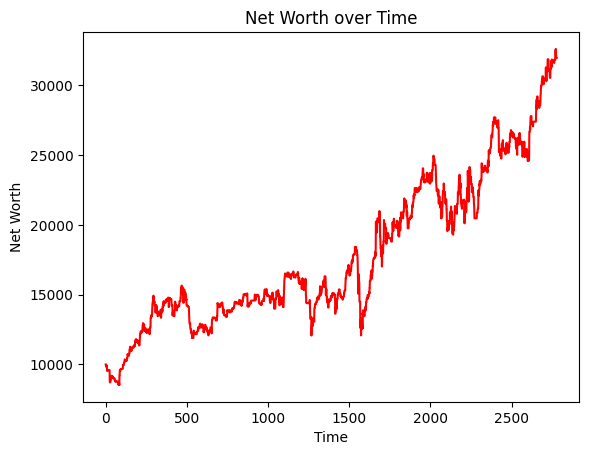

In [178]:
import matplotlib.pyplot as plt


# Plot the net worth over time
plt.plot(net_worth,color='red')
plt.xlabel("Time")
plt.ylabel("Net Worth")
plt.title("Net Worth over Time")
plt.show()

In [179]:
print(net_worth)

[10000, np.float64(10000.0), np.float64(10000.0), np.float64(9957.465651945282), np.float64(9957.465651945282), np.float64(9890.043641233131), np.float64(9791.47261390706), np.float64(9906.497783729787), np.float64(9766.8753553957), np.float64(9551.865460442035), np.float64(9604.06828306178), np.float64(9535.23040795809), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(9595.752923406484), np.float64(8827.093165425347), np.float64(8726.645166964738), np.float64(8709.698774681181), np.float64(8724.021371586092), np.float64(8740.26997439153), np.float64(8867.097623352542), np.float64(8933.480662370976), np.float64(8933.480662370976), np.float64(9058.7571896973

In [180]:
def evaluate_model(model, env, num_episodes=10):
    total_rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        total_rewards.append(total_reward)

    avg_total_reward = np.mean(total_rewards)
    print(f"Average total reward over {num_episodes} episodes: {avg_total_reward}")



In [ ]:
test_env = TradingEnvironment(test_data)
evaluate_model(model, test_env)
